### Read data

In [1]:
import pickle

with open("data.p", "rb") as f:
    faces = pickle.load(f)
    
images = faces.images    
targets = faces.target
target_names = faces.target_names

print(targets.shape)
print(images.shape)
print(images[0].shape)

(1348,)
(1348, 62, 47)
(62, 47)


### Data Visualization

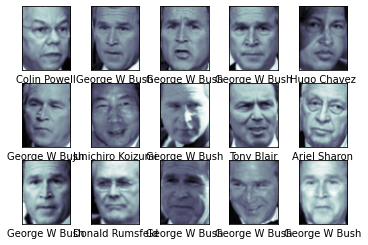

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=target_names[targets[i]])

### Preprocessing of data

In [150]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

number, height, width = images.shape

#flattening images

X = images.reshape(number, height*width)

#standardization

X = StandardScaler().fit_transform(X)

#train_validation_test splitting

test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=test_size, shuffle=False)

### SVM


Количество правильно классифицированных картин = 318


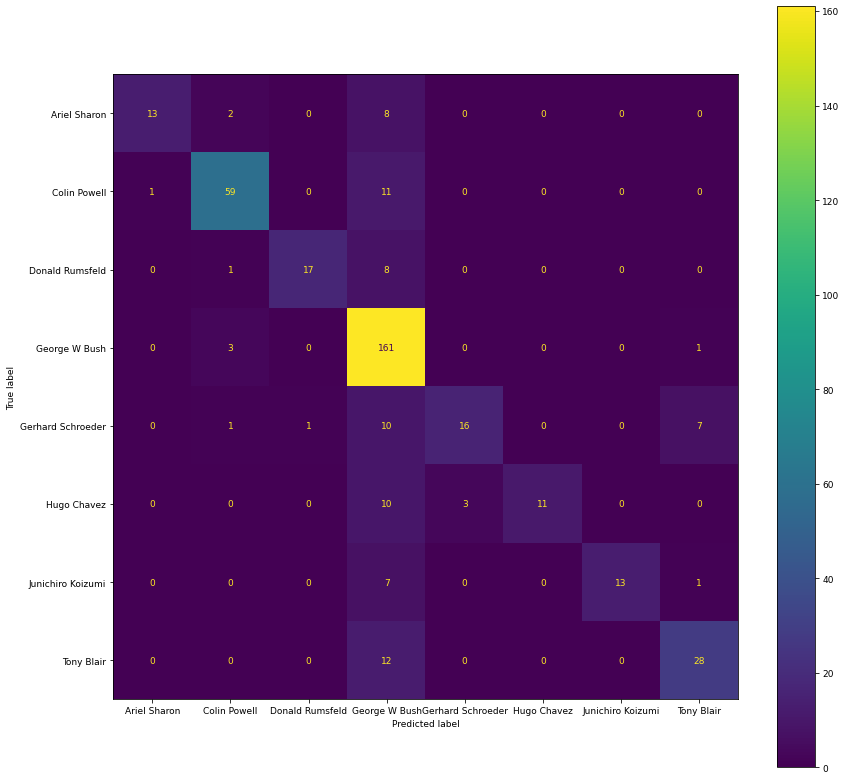

In [151]:
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

baseline_svm = svm.SVC()
baseline_svm.fit(X_train, y_train)
y_pred_svm = baseline_svm.predict(X_test)

def visualize_conf_mat(y_test, y_pred):
    font = {'size' : 9}
    plt.rc('font', **font)
    conf_mat = confusion_matrix(y_test, y_pred)
    print(f'Количество правильно классифицированных картин = {np.trace(conf_mat)}')
    display = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=target_names)
    fig, ax = plt.subplots(figsize=(14,14))  
    display.plot(ax=ax)
    plt.show()
    
visualize_conf_mat(y_test, y_pred_svm)

#### Hyperparameters selection

In [152]:
from sklearn.model_selection import GridSearchCV

params = {
    'C' : [0.15, 0.5, 1.0],
    'kernel' : ('poly', 'rbf', 'sigmoid'),
    'degree' : [1, 2, 3],
    'gamma' : ['scale', 0.15, 0.5, 1.0]
}

svm_with_search = GridSearchCV(svm.SVC(), params)
svm_with_search.fit(X_train, y_train)
svm_with_search.best_params_

{'C': 0.15, 'degree': 1, 'gamma': 0.15, 'kernel': 'poly'}

Количество правильно классифицированных картин = 351


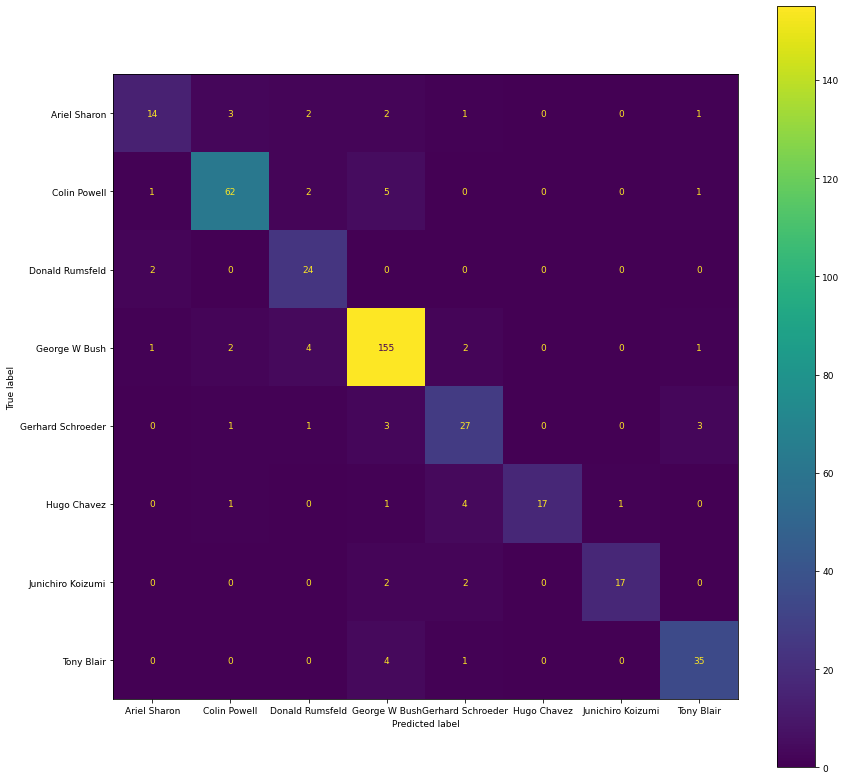

In [153]:
best_svm = svm.SVC(**svm_with_search.best_params_)
best_svm.fit(X_train, y_train)
y_pred_svm_new = best_svm.predict(X_test)
visualize_conf_mat(y_test, y_pred_svm_new)

После подбора гиперпараметров количество правильно классифицированных картин увеличилось на чуть более, чем 10 %

#### Optimization by adding class weights

Количество правильно классифицированных картин = 351


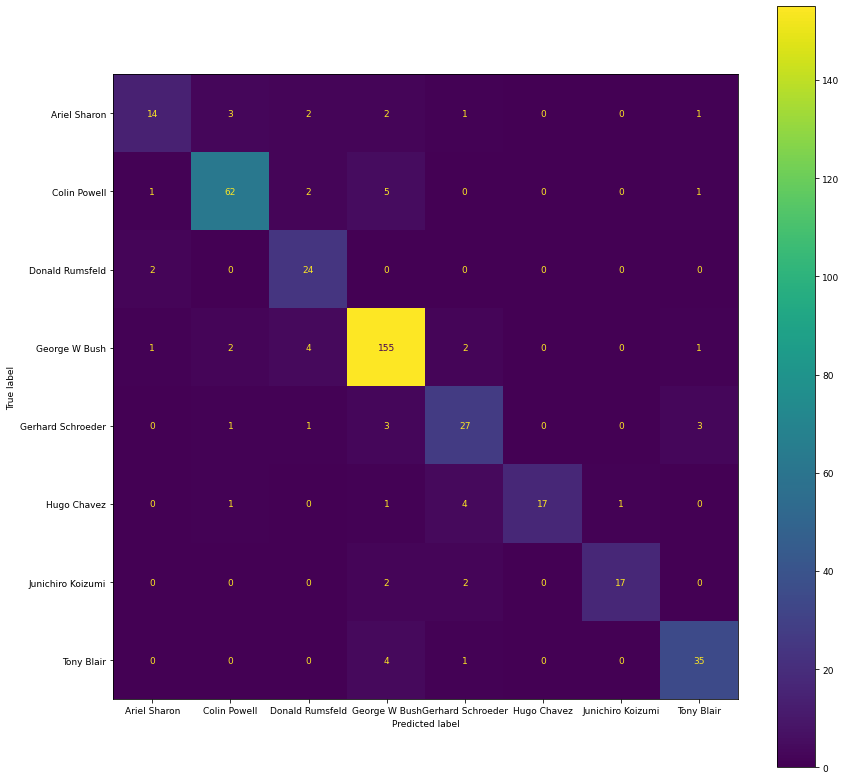

In [154]:
from sklearn.utils.class_weight import compute_class_weight

class_weight_vect = compute_class_weight('balanced', classes=targets, y=y_train)

class_weights = {k:v for k, v in zip(targets, class_weight_vect)}

balanced_svm = svm.SVC(**svm_with_search.best_params_, class_weight=class_weights)
balanced_svm.fit(X_train, y_train)
y_pred_svm_balanced = balanced_svm.predict(X_test)
visualize_conf_mat(y_test, y_pred_svm_balanced)

#### Upsampling

In [167]:
_, counts = np.unique(y_train, return_counts=True)
total, = y_train.shape
percent_of_images = [round((count / total) * 100, 1) for count in counts]
president_freq = \
pd.DataFrame(data={'President' : target_names, 'Number of images' : counts, '% of all images' : percent_of_images})
president_freq

,President,Number of images,% of all images
0,Ariel Sharon,54,5.7
1,Colin Powell,165,17.5
2,Donald Rumsfeld,95,10.1
3,George W Bush,365,38.7
4,Gerhard Schroeder,74,7.8
5,Hugo Chavez,47,5.0
6,Junichiro Koizumi,39,4.1
7,Tony Blair,104,11.0


Видим, что самый часто встречающийся президент - Джордж Буш. Дополним каждый класс до количества, равного количеству изображений с бывшим президентом США

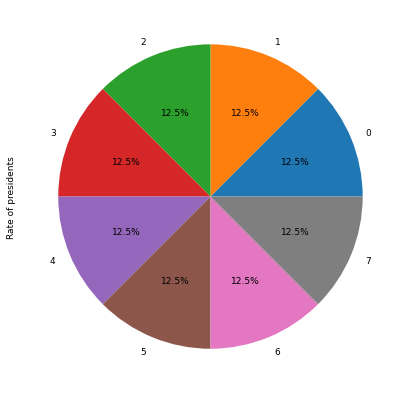

In [200]:
from sklearn.utils import resample

df = pd.DataFrame(X_train)
df['target'] = y_train
#needed_num, _ = df[df['target'] == 3].shape # Количество изображений с Бушем

for i in range(len(target_names)):
    if i != 3:
        current_num, _ = df[df['target'] == i].shape
        upsample = resample(df[df['target'] == i],
                  n_samples=needed_num-current_num,
                  random_state=42)
        df = pd.concat([df, upsample], axis=0)

plt.figure(figsize=(7, 7))
df.groupby('target').size().plot(kind='pie',
                                 label = "Rate of presidents",
                                 autopct='%1.1f%%')
plt.show()

Количество правильно классифицированных картин = 351


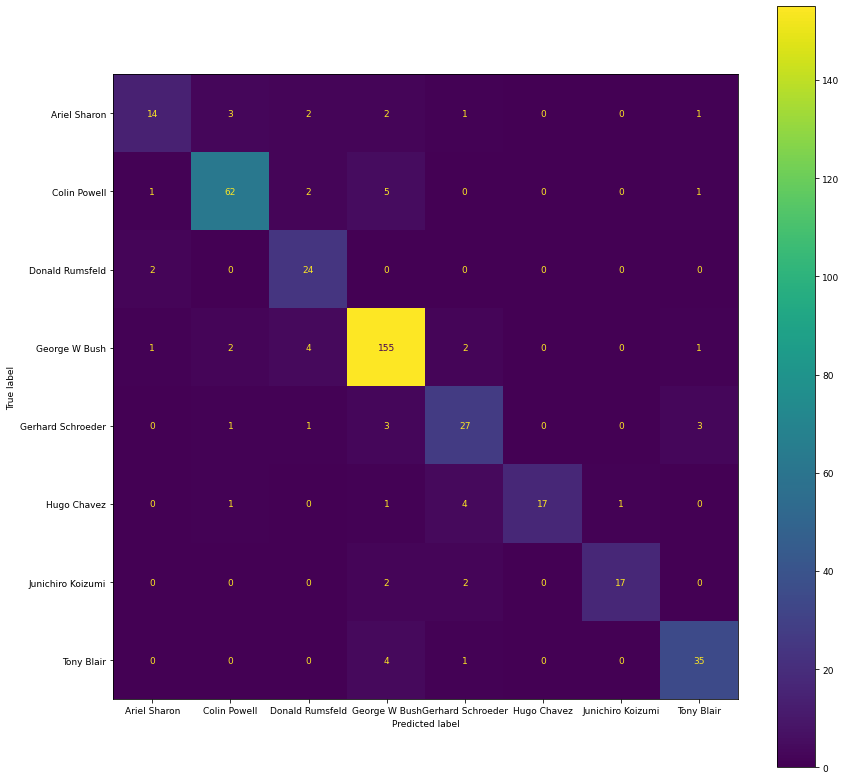

In [206]:
df_samples = df.drop(['target'], axis=1)
df_targets = df['target']
best_svm.fit(df_samples, df_targets)
y_pred_svm_added = best_svm.predict(X_test)
visualize_conf_mat(y_test, y_pred_added)

Upsampling не дал улучшений

### Random forest

Количество правильно классифицированных картин = 265


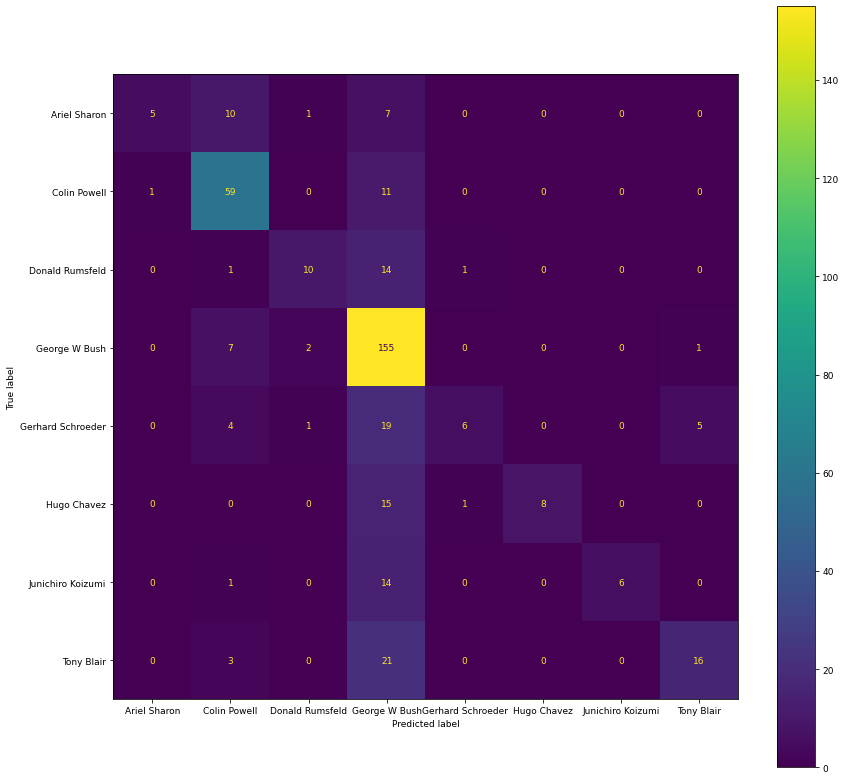

In [156]:
from sklearn.ensemble import RandomForestClassifier

baseline_rf = RandomForestClassifier()
baseline_rf.fit(X_train, y_train)
y_pred_rf = baseline_rf.predict(X_test)

visualize_conf_mat(y_test, y_pred_rf)

#### Hyperparameters selection

In [157]:
params = {
    'n_estimators' : [2, 5, 15, 25, 50, 75, 100],
    'max_depth': [None, 2, 4, 6, 8],
    'criterion' : ('gini', 'entropy')
}

rf_with_search = GridSearchCV(RandomForestClassifier(random_state=42), params)
rf_with_search.fit(X_train, y_train)
rf_with_search.best_params_

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}

Количество правильно классифицированных картин = 284


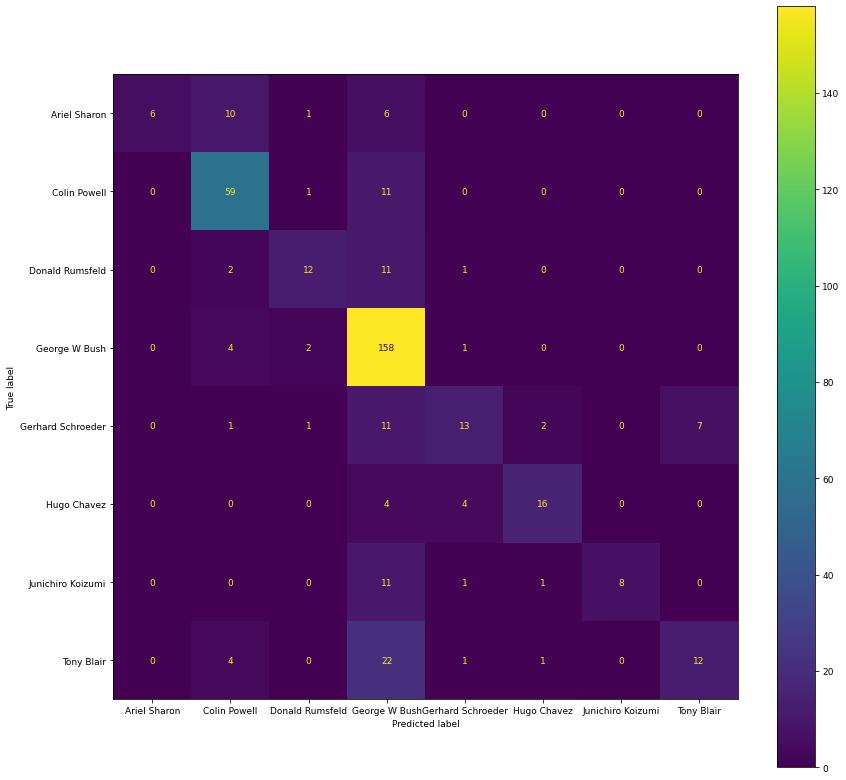

In [158]:
best_rf = RandomForestClassifier(**rf_with_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)
y_pred_rf_new = best_rf.predict(X_test)
visualize_conf_mat(y_test, y_pred_rf_new)

После подбора гиперпараметров количество правильно классифицированных картин увеличилось на чуть более, чем 7 %

#### Optimization by adding class weights

Количество правильно классифицированных картин = 263


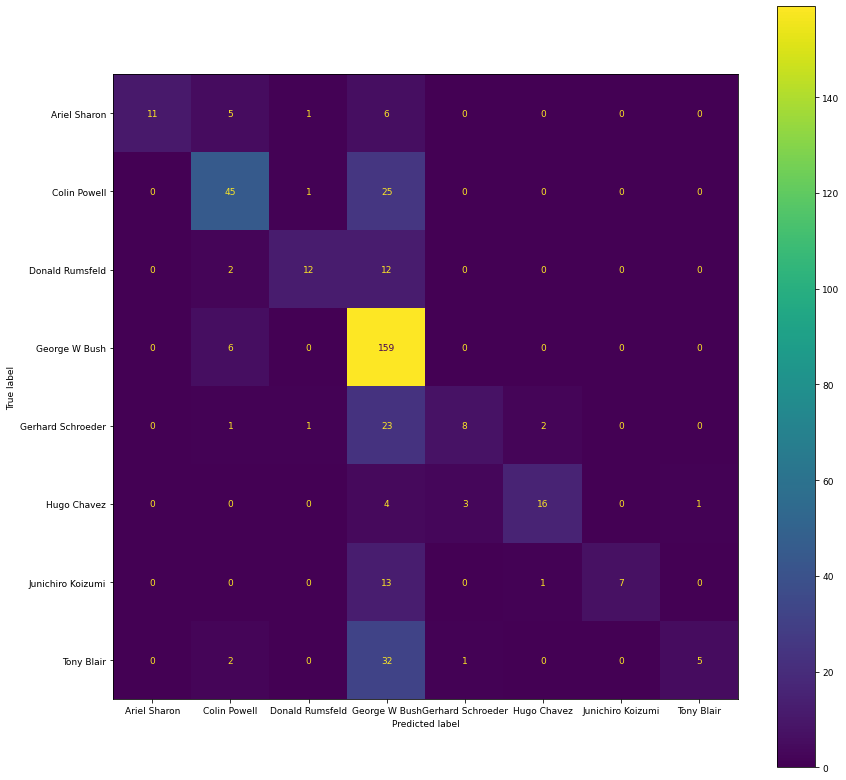

In [159]:
balanced_rf = RandomForestClassifier(**rf_with_search.best_params_, class_weight=class_weights)
balanced_rf.fit(X_train, y_train)
y_pred_rf_balanced = balanced_rf.predict(X_test)
visualize_conf_mat(y_test, y_pred_rf_balanced)

Добавление весов ухудшило ситуацию

#### Upsampling

Количество правильно классифицированных картин = 292


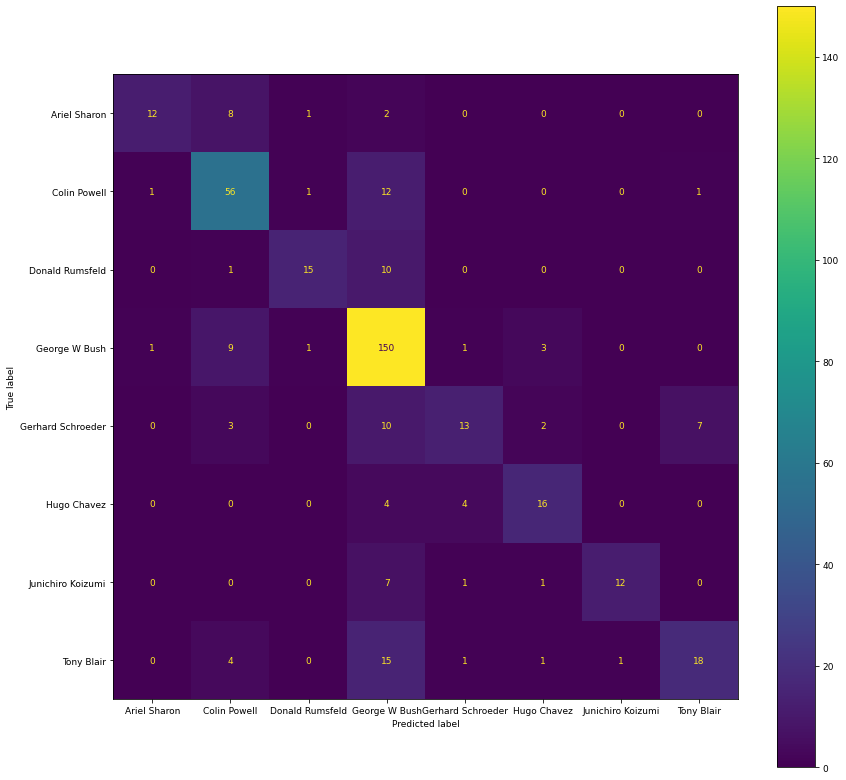

In [208]:
best_rf.fit(df_samples, df_targets)
y_pred_rf_added = best_rf.predict(X_test)
visualize_conf_mat(y_test, y_pred_rf_added)

С апсемплингом получился наилучший результат, количество правильно класифицированных изображений увеличилась на 10 % по сравнению с бейзлайном